# 뉴스 카테고리 다중분류

## 프로젝트 설명

모델을 변경하고 조합해서 성능을 올리는 방법도 있지만 사용하는 단어의 수에 따라 성능이 달라질 수도 있다.

중요도가 낮은 단어들까지 포함해 너무 많은 단어를 사용하는 경우나 너무 적은 단어들을 사용하는 경우 성능이 낮아질 수 있다.

이렇게 변화된 단어의 수는 어떤 모델을 사용하느냐에 따라 유리할 수도, 불리할 수도 있다.

따라서 모든 단어를 사용하는 경우, 빈도수 상위 3000개, 5000개, 10000개, 20000개의 단어만 사용하는 경우 총 5가지의 경우에 대해서 8개의 머신 러닝 모델과 1개의 딥러닝 모델을 사용하여 성능 분석을 진행한다.

모델의 종류는 다음과 같다.
- Naive Bayse
- Complement Naive Bayse
- Logistic Regression
- Support Vector Machine
- Decision Tree
- Random Forest
- Gradient Boosting Tree
- Voting
- 1D-CNN

M2 팀원 세 명이 각각 세 개의 모델을 담당하여 실험 진행 후 결과를 취합하는 방식으로 진행한다.

따라서 이번 노트북 파일에는 9개의 모델 중 Logistic Regression, Random Forest, 1D-CNN을 사용한 실험만 진행하였다.

## 프로젝트 루브릭

|학습 목표|평가 기준|
|---------|---------|
|분류 모델의 accuracy가 기준 이상 높게 나왔는가?|3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.|
|분류 모델의 F1 score가 기준 이상 높게 나왔는가?|Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, <br>해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.|
|딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?|동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.|

# 사전 환경 세팅

## Colab 환경 세팅 함수 정의

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/AIFFEL/Deep_Dive/work/reuters_classification

Mounted at /content/drive
/content/drive/MyDrive/AIFFEL/Deep_Dive/work/reuters_classification


## LMS 환경 세팅 함수 정의

In [ ]:
!mkdir -p ~/work/reuters_classification/data
!ln -s ~/data/* ~/work/reuters_classification/data/

## 환경 세팅

# 라이브러리 설치 및 호출

## 라이브러리 설치

In [ ]:
!pip install konlpy sentencepiece soynlp scikit-learn
!apt-get install -y openjdk-17-jdk
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd ./Mecab-ko-for-Google-Colab/
!bash install_mecab-ko_on_colab_light_220429.sh
%cd /content/drive/MyDrive/AIFFEL/Deep_Dive/work/reuters_classification

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 94.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 416.8/416.8 kB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.9/495.9 kB 26.5 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  at-spi2-core fonts-dejavu-core fonts-dejavu-extra gsettings-desktop-schemas
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libgail-common libgail18 libgtk2.0-0
  libgtk2.0-bin libgtk2.0-common librsvg2-common libxcomposite1 libxt-dev
  libxtst6 libxxf86dga1 openjdk-17-jre session-migration x11-utils
Suggested packages:
  gvfs libxt-doc openjdk-17-demo openjdk-17-source visualvm mesa-utils
The following NEW packages will be installed:
  at-spi2-core fonts-dejavu-core fonts-dejavu-extra gsettings-desktop-schemas
  libatk-bridge2.0-0 libatk-wr

## 라이브러리 호출

In [2]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib
import sklearn

In [3]:
import json
import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB #다항분포 나이브 베이즈 모델
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score #정확도 계산

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.base import BaseEstimator, ClassifierMixin

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split

## 라이브러리 버전 확인

In [ ]:
print(torch.__version__)
print(matplotlib.__version__)
print(sns.__version__)
print(np.__version__)
print(pd.__version__)
print(sklearn.__version__)

2.8.0+cu126
3.10.0
0.13.2
2.0.2
2.2.2
1.6.1


# 데이터 분석

## 데이터 다운로드 및 열기

In [ ]:
data_dir = "./data/"

x_train = np.load(data_dir + "x_train.npy", allow_pickle=True)
y_train = np.load(data_dir + "y_train.npy", allow_pickle=True)
x_test = np.load(data_dir + "x_test.npy", allow_pickle=True)
y_test = np.load(data_dir + "y_test.npy", allow_pickle=True)

x_train_seq = np.load(data_dir + "x_train.npy", allow_pickle=True)
x_test_seq = np.load(data_dir + "x_test.npy", allow_pickle=True)

## 데이터 확인하기

In [ ]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [ ]:
print(x_train[0])
print(x_test[0])

[1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]
[1, 4, 1378, 2025, 9, 697, 4622, 111, 8, 25, 109, 29, 3650, 11, 150, 244, 364, 33, 30, 30, 1398, 333, 6, 2, 159, 9, 1084, 363, 13, 2, 71, 9, 2, 71, 117, 4, 225, 78, 206, 10, 9, 1214, 8, 4, 270, 5, 2, 7, 748, 48, 9, 2, 7, 207, 1451, 966, 1864, 793, 97, 133, 336, 7, 4, 493, 98, 273, 104, 284, 25, 39, 338, 22, 905, 220, 3465, 644, 59, 20, 6, 119, 61, 11, 15, 58, 579, 26, 10, 67, 7, 4, 738, 98, 43, 88, 333, 722, 12, 20, 6, 19, 746, 35, 15, 10, 9, 1214, 855, 129, 783, 21, 4, 2280, 244, 364, 51, 16, 299, 452, 16, 515, 4, 99, 29, 5, 4, 364, 281, 48, 10, 9, 1214, 23, 644, 47, 20, 324, 27, 56, 2, 2, 5, 192, 510, 17, 12]


In [ ]:
print(y_train[0])
print(y_test[0])

3
3


In [ ]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


## 데이터 시각화

훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


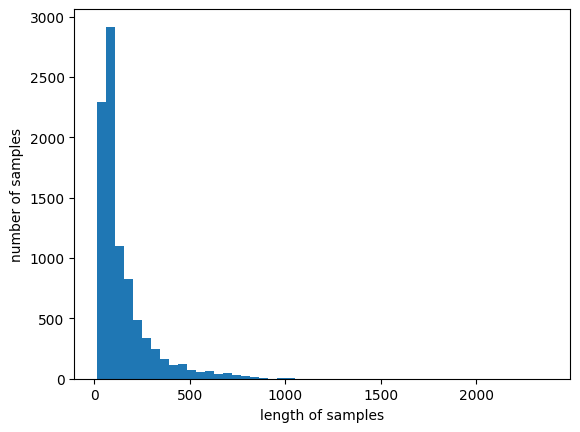

In [ ]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

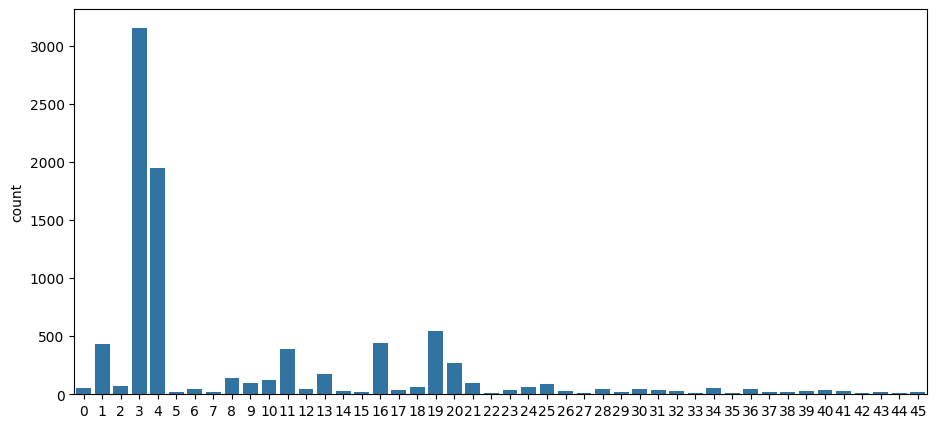

In [ ]:
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(11,5)
sns.countplot(x=y_train)
plt.show()

In [ ]:
unique_elements, counts_elements = np.unique(y_train, return_counts=True)
print("각 클래스 빈도수:")
print(np.asarray((unique_elements, counts_elements)))

각 클래스 빈도수:
[[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
    14   15   16   17   18   19   20   21   22   23   24   25   26   27
    28   29   30   31   32   33   34   35   36   37   38   39   40   41
    42   43   44   45]
 [  55  432   74 3159 1949   17   48   16  139  101  124  390   49  172
    26   20  444   39   66  549  269  100   15   41   62   92   24   15
    48   19   45   39   32   11   50   10   49   19   19   24   36   30
    13   21   12   18]]


## 데이터 복원하기

In [ ]:
# word_index = reuters.get_word_index(path="reuters_word_index.json")
!wget https://storage.googleapis.com/tensorflow/tf-keras-datasets/reuters_word_index.json

# 1. 파일 열기
with open('reuters_word_index.json', 'r', encoding='utf-8') as f:
    # 2. JSON 로드
    word_index = json.load(f)

--2025-11-18 04:49:36--  https://storage.googleapis.com/tensorflow/tf-keras-datasets/reuters_word_index.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.204.207, 64.233.187.207, 64.233.188.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.204.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 550378 (537K) [application/json]
Saving to: ‘reuters_word_index.json.10’

reuters_word_index. 100%[===================>] 537.48K   896KB/s    in 0.6s    

2025-11-18 04:49:37 (896 KB/s) - ‘reuters_word_index.json.10’ saved [550378/550378]



In [ ]:
word_index['the']

1

In [ ]:
word_index['it']

13

In [ ]:
index_to_word = { index+3 : word for word, index in word_index.items() }

In [ ]:
print(index_to_word[4])
print(index_to_word[16])

the
it


In [ ]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [ ]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [ ]:
decoded = []
for i in range(len(x_train)):
    t = ' '.join([index_to_word[index] for index in x_train[i]])
    decoded.append(t)

x_train = decoded
print(len(x_train))

8982


In [ ]:
#test데이터도 변환해주세요!

decoded = []
for i in range(len(x_test)):
    t = ' '.join([index_to_word[index] for index in x_test[i]])
    decoded.append(t)

x_test = decoded
print(len(x_test))

2246


In [ ]:
x_train[:5]

['<sos> <unk> <unk> said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3',
 '<sos> generale de banque sa lt <unk> br and lt heller overseas corp of chicago have each taken 50 pct stakes in <unk> company sa <unk> factors generale de banque said in a statement it gave no financial details of the transaction sa <unk> <unk> turnover in 1986 was 17 5 billion belgian francs reuter 3',
 '<sos> shr 3 28 dlrs vs 22 cts shr diluted 2 99 dlrs vs 22 cts net 46 0 mln vs 3 328 000 avg shrs 14 0 mln vs 15 2 mln year shr 5 41 dlrs vs 1 56 dlrs shr diluted 4 94 dlrs vs 1 50 dlrs net 78 2 mln vs 25 9 mln avg shrs 14 5 mln vs 15 1 mln note earnings per share reflect the two for o

In [ ]:
x_test[:5]

['<sos> the great atlantic and pacific tea co said its three year 345 mln dlr capital program will be be substantially increased to <unk> growth and expansion plans for <unk> inc and <unk> inc over the next two years a and p said the acquisition of <unk> in august 1986 and <unk> in december helped us achieve better than expected results in the fourth quarter ended february 28 its net income from continuing operations jumped 52 6 pct to 20 7 mln dlrs or 55 cts a share in the latest quarter as sales increased 48 3 pct to 1 58 billion dlrs a and p gave no details on the expanded capital program but it did say it completed the first year of the program during 1986 a and p is 52 4 pct owned by lt <unk> <unk> of west germany reuter 3',
 "<sos> philippine sugar production in the 1987 88 crop year ending august has been set at 1 6 mln tonnes up from a provisional 1 3 mln tonnes this year sugar regulatory administration <unk> chairman <unk> yulo said yulo told reuters a survey during the curren

# 벡터화하기

In [ ]:
dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 9670)


In [ ]:
tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 9670)


In [ ]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변환"

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

def build_tfidf(x_train_texts, x_test_texts, max_features=None):
    """
    x_train_texts, x_test_texts: 리스트[str]
    max_features: vocab_size (None이면 전체 단어 사용)
    return: tfidfv_train, tfidfv_test, fitted_vectorizer
    """
    dtmvector = CountVectorizer(max_features=max_features)
    x_train_dtm = dtmvector.fit_transform(x_train_texts)

    tfidf_transformer = TfidfTransformer()
    tfidfv_train = tfidf_transformer.fit_transform(x_train_dtm)

    x_test_dtm = dtmvector.transform(x_test_texts)
    tfidfv_test = tfidf_transformer.transform(x_test_dtm)

    return tfidfv_train, tfidfv_test, dtmvector

In [ ]:
tfidfv, tfidfv_test, vectorizer = build_tfidf(x_train, x_test, max_features=None)

# 가설 설정

## 모델에 따라 성능이 달라질 것이다.
통제 변인 : vocab_size=5000, 전처리 방식, 사용 데이터

종속 변인 : 모델 종류 (Naive Bayse, Complement Naive Bayse, Logistic Regression, SVM, Decision Tree, Random Forest, Gradient Boosting Tree, Voting, 1D-CNN)

실험 방법 : 각 모델마다 동일한 vocab_size로 학습 진행 후 예측 정확도(macro f1-score) 계산

산출물 : 모델에 따른 정확도 막대 그래프와 macro-f1-score 막대 그래프

## Vocab Size에 따라 모델 성능이 달라질 것이다.
통제 변인 : 모델 종류, 전처리 방식, 사용 데이터

종속 변인 : vocab_size = [3000, 5000, 10000, 20000]

실험 방법 : vocab_size에 따라 모델 학습 진행 후 예측 정확도(macro f1-score) 계산

산출물 : 각 모델 별 vocab_size에 따른 정확도 그래프와 macro f1-score 그래프

# 모델 구현(1D-CNN)

## 시퀀스 입력, 임베딩 없는 1D-CNN
- 변인 통제에만 집중하여 모델의 특성을 고려하지 않은 채로 실험을 진행함.
- 딥러닝 모델의 경우 토큰의 순서를 함께 학습해야 성능이 올라간다고 함.
- 실제로 변경 후 모델의 accuracy가 0.3에서 0.8까지 향상되었음.

In [ ]:
class SimpleCNN1D(nn.Module):
    def __init__(self, input_dim, num_classes, num_filters=128, kernel_size=5):
        super().__init__()
        # X shape: (batch, input_dim) -> (batch, 1, input_dim)
        self.conv = nn.Conv1d(
            in_channels=1,
            out_channels=num_filters,
            kernel_size=kernel_size
        )
        self.relu = nn.ReLU()
        self.fc = nn.Linear(num_filters, num_classes)

    def forward(self, x):
        # x: (batch, input_dim)
        x = x.unsqueeze(1)               # (batch, 1, input_dim)
        x = self.conv(x)                 # (batch, C, L')
        x = self.relu(x)
        x = torch.max(x, dim=2).values   # global max pooling -> (batch, C)
        logits = self.fc(x)              # (batch, num_classes)
        return logits

In [ ]:
class CNN1DClassifier(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        num_epochs=5,
        batch_size=64,
        lr=1e-3,
        verbose=1,
        device=None,
    ):
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.lr = lr
        self.verbose = verbose
        self.device = device if device is not None else (
            "cuda" if torch.cuda.is_available() else "cpu"
        )

        # 나중에 fit에서 채워지는 속성들
        self.model_ = None
        self.input_dim_ = None
        self.num_classes_ = None

    def _build_model(self, input_dim, num_classes):
        self.model_ = SimpleCNN1D(
            input_dim=input_dim,
            num_classes=num_classes
        ).to(self.device)

    def fit(self, X, y):
        """X: TF-IDF (sparse or dense), y: label 배열"""
        # 1) 입력/레이블 차원 파악
        if hasattr(X, "shape"):
            n_samples, input_dim = X.shape
        else:
            X = np.asarray(X)
            n_samples, input_dim = X.shape

        y = np.asarray(y)
        num_classes = int(y.max()) + 1

        self.input_dim_ = input_dim
        self.num_classes_ = num_classes

        # 2) PyTorch 텐서로 변환 (sparse면 dense로 변환)
        if hasattr(X, "toarray"):  # scipy.sparse
            X_tensor = torch.tensor(X.toarray(), dtype=torch.float32)
        else:
            X_tensor = torch.tensor(X, dtype=torch.float32)

        y_tensor = torch.tensor(y, dtype=torch.long)

        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

        # 3) 모델/옵티마이저/손실함수 준비 (매 fit마다 새로 초기화)
        self._build_model(input_dim, num_classes)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model_.parameters(), lr=self.lr)

        self.model_.train()
        for epoch in range(self.num_epochs):
            epoch_loss = 0.0
            correct = 0
            total = 0
            for xb, yb in loader:
                xb = xb.to(self.device)
                yb = yb.to(self.device)

                optimizer.zero_grad()
                logits = self.model_(xb)
                loss = criterion(logits, yb)
                loss.backward()
                optimizer.step()

                epoch_loss += loss.item() * xb.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += xb.size(0)

            if self.verbose:
                print(
                    f"[CNN1D] Epoch {epoch+1}/{self.num_epochs} "
                    f"Loss: {epoch_loss / total:.4f}  Acc: {correct / total:.4f}"
                )

        return self

    def predict(self, X):
        """sklearn의 predict 인터페이스"""
        if hasattr(X, "toarray"):  # sparse
            X_tensor = torch.tensor(X.toarray(), dtype=torch.float32)
        else:
            X_tensor = torch.tensor(X, dtype=torch.float32)

        self.model_.eval()
        preds = []

        with torch.no_grad():
            for i in range(0, X_tensor.size(0), self.batch_size):
                xb = X_tensor[i : i + self.batch_size].to(self.device)
                logits = self.model_(xb)
                batch_preds = logits.argmax(dim=1).cpu().numpy()
                preds.append(batch_preds)

        preds = np.concatenate(preds, axis=0)
        return preds

## 시퀀스 입력 + 임베딩 추가

### 기존 1D-CNN에서 변경된 부분

- vocab 구성할 때, TF-IDF 기반으로 진행
- sikit-learn에서 사용하는 fit() 함수로 명칭 변경

In [ ]:
UNK_ID = 0       # 0: <unk> + pad
MAX_SEQ_LEN = 300

def build_sequences_from_vectorizer(texts, vectorizer, unk_id=UNK_ID):
    """
    TF-IDF에 사용된 vectorizer의 analyzer와 vocab을 그대로 사용해서
    TextCNN용 정수 시퀀스를 만든다.
    - texts: 리스트[str]
    - vectorizer: CountVectorizer (fit 완료)
    return: (sequences, vocab_size_for_textcnn)
    """
    analyzer = vectorizer.build_analyzer()  # CountVectorizer와 동일한 전처리/토크나이저
    vocab_words = vectorizer.get_feature_names_out()

    # TextCNN용 word_index: 1..V까지 할당 (0은 pad/unk)
    word_index = {w: i+1 for i, w in enumerate(vocab_words)}

    sequences = []
    for text in texts:
        tokens = analyzer(text)
        ids = [word_index.get(tok, unk_id) for tok in tokens]
        sequences.append(ids)
    vocab_size_for_textcnn = len(word_index) + 1  # 0 포함한 전체 크기
    return sequences, vocab_size_for_textcnn

def pad_sequences(seqs, maxlen, padding_value=UNK_ID):
    padded = np.full((len(seqs), maxlen), padding_value, dtype=np.int64)
    for i, s in enumerate(seqs):
        trunc = s[:maxlen]
        padded[i, :len(trunc)] = trunc
    return padded

In [ ]:
class TextCNN(nn.Module):
    def __init__(
        self,
        vocab_size,
        embed_dim,
        num_classes,
        filter_sizes=(3, 4, 5),
        num_filters=100,
        dropout=0.5,
        padding_idx=UNK_ID,
    ):
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim,
            padding_idx=padding_idx,
        )
        self.convs = nn.ModuleList([
            nn.Conv1d(
                in_channels=embed_dim,
                out_channels=num_filters,
                kernel_size=fs
            )
            for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(filter_sizes), num_classes)

    def forward(self, x):
        # x: (batch, seq_len)
        x = self.embedding(x)        # (batch, seq_len, embed_dim)
        x = x.transpose(1, 2)        # (batch, embed_dim, seq_len)

        conv_outs = []
        for conv in self.convs:
            c = torch.relu(conv(x))          # (batch, num_filters, L')
            c = torch.max(c, dim=2).values   # (batch, num_filters)
            conv_outs.append(c)

        x = torch.cat(conv_outs, dim=1)      # (batch, num_filters * len(filter_sizes))
        x = self.dropout(x)
        logits = self.fc(x)                  # (batch, num_classes)
        return logits

In [ ]:
class TextCNNClassifier(BaseEstimator, ClassifierMixin):
    def __init__(
        self,
        vocab_size,
        num_classes,
        embed_dim=128,
        filter_sizes=(3, 4, 5),
        num_filters=100,
        dropout=0.5,
        batch_size=64,
        num_epochs=10,
        lr=1e-3,
        device=None,
        verbose=1,
    ):
        self.vocab_size = vocab_size
        self.num_classes = num_classes
        self.embed_dim = embed_dim
        self.filter_sizes = filter_sizes
        self.num_filters = num_filters
        self.dropout = dropout
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.lr = lr
        self.device = device if device is not None else (
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        self.verbose = verbose
        self.model_ = None

    def _build_model(self):
        self.model_ = TextCNN(
            vocab_size=self.vocab_size,
            embed_dim=self.embed_dim,
            num_classes=self.num_classes,
            filter_sizes=self.filter_sizes,
            num_filters=self.num_filters,
            dropout=self.dropout,
            padding_idx=UNK_ID,
        ).to(self.device)

    def fit(self, X, y, X_val=None, y_val=None):
        X = np.asarray(X, dtype=np.int64)
        y = np.asarray(y, dtype=np.int64)

        train_ds = TensorDataset(
            torch.tensor(X, dtype=torch.long),
            torch.tensor(y, dtype=torch.long),
        )
        train_loader = DataLoader(train_ds, batch_size=self.batch_size, shuffle=True)

        if X_val is not None and y_val is not None:
            X_val = np.asarray(X_val, dtype=np.int64)
            y_val = np.asarray(y_val, dtype=np.int64)
            val_ds = TensorDataset(
                torch.tensor(X_val, dtype=torch.long),
                torch.tensor(y_val, dtype=torch.long),
            )
            val_loader = DataLoader(val_ds, batch_size=self.batch_size, shuffle=False)
        else:
            val_loader = None

        self._build_model()
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.model_.parameters(), lr=self.lr)

        for epoch in range(self.num_epochs):
            self.model_.train()
            total_loss = 0.0
            correct = 0
            total = 0

            for xb, yb in train_loader:
                xb = xb.to(self.device)
                yb = yb.to(self.device)

                optimizer.zero_grad()
                logits = self.model_(xb)
                loss = criterion(logits, yb)
                loss.backward()
                optimizer.step()

                total_loss += loss.item() * xb.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += xb.size(0)

            msg = ""
            if total > 0:
                train_loss = total_loss / total
                train_acc = correct / total
                msg = f"[TextCNN] Epoch {epoch+1}/{self.num_epochs}  loss={train_loss:.4f}  acc={train_acc:.4f}"

            if val_loader is not None:
                val_acc, val_loss = self._eval_on_loader(val_loader, criterion)
                msg += f"  val_loss={val_loss:.4f}  val_acc={val_acc:.4f}"

            if self.verbose and msg:
                print(msg)

        return self

    def _eval_on_loader(self, loader, criterion):
        self.model_.eval()
        total_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(self.device)
                yb = yb.to(self.device)
                logits = self.model_(xb)
                loss = criterion(logits, yb)

                total_loss += loss.item() * xb.size(0)
                preds = logits.argmax(dim=1)
                correct += (preds == yb).sum().item()
                total += xb.size(0)

        return correct / total, total_loss / total

    def predict(self, X):
        X = np.asarray(X, dtype=np.int64)
        ds = TensorDataset(torch.tensor(X, dtype=torch.long))
        loader = DataLoader(ds, batch_size=self.batch_size, shuffle=False)

        self.model_.eval()
        all_preds = []
        with torch.no_grad():
            for (xb,) in loader:
                xb = xb.to(self.device)
                logits = self.model_(xb)
                preds = logits.argmax(dim=1).cpu().numpy()
                all_preds.append(preds)

        return np.concatenate(all_preds, axis=0)

In [ ]:
y_train = np.array(y_train)
y_test  = np.array(y_test)

N = len(x_train)
all_idx = np.arange(N)
train_idx, val_idx = train_test_split(
    all_idx,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)

# 모델 학습 파이프라인 설계
- 입력 : 모델 리스트
- 출력 : 모델 별, vocab_size 별 - 정확도, f1-macro-score 표, 가설 1, 2에 대한 시각화 그래프

# 모델 학습 함수 정의

## train 함수 정의

In [ ]:
def model_train(models_dict, X_train, y_train):
    """
    models_dict: {"name": model_object, ...}
    X_train: TF-IDF sparse matrix
    y_train: labels
    return:
        trained_models, train_times (dict)
    """
    trained_models = {}
    train_times = {}

    for name, model in models_dict.items():
        print(f"[{name}] fit started")

        start_time = time.perf_counter()
        model.fit(X_train, y_train)
        end_time = time.perf_counter()

        elapsed = end_time - start_time
        train_times[name] = elapsed
        trained_models[name] = model

        print(f"[{name}] fit finished   (⏱ {elapsed:.3f} 초)")

    return trained_models, train_times

In [ ]:
def train_textcnn(textcnn, X_tr, y_tr, X_val, y_val):
    print(f"TextCNN fit started")
    start = time.perf_counter()
    textcnn.fit(X_tr, y_tr, X_val=X_val, y_val=y_val)
    end = time.perf_counter()
    elapsed = end - start
    print(f"TextCNN fit finished   (⏱ {elapsed:.3f} 초)")
    return textcnn, elapsed

## 모델 평가 지표 함수 정의

In [ ]:
def accuracy_f1_macro(model, X_test, y_test):
    """
    단일 모델에 대해 accuracy, macro F1 계산
    """
    predicted = model.predict(X_test)
    acc = accuracy_score(y_test, predicted)
    macro_f1 = f1_score(y_test, predicted, average='macro')
    print("정확도:", acc)
    print("Macro F1-score:", macro_f1)
    return acc, macro_f1

## 시각화 함수 정의

In [4]:
import matplotlib.pyplot as plt

def plot_metrics_by_vocab(
    df,
    exclude_minus_one: bool = True,
    include_models: list[str] | None = None,
):
    """
    df: model, vocab_size, accuracy, macro_f1 컬럼을 가진 DataFrame
    exclude_minus_one: vocab_size == -1 (full vocab) 제거할지 여부
    include_models: 특정 모델만 보고 싶을 때 리스트로 지정 (예: ["Logistic Regression", "TextCNN"])
                    None이면 df에 있는 모든 모델 사용
    """

    data = df.copy()

    # 1) vocab_size -1 제거 옵션 (full vocab 제외)
    if exclude_minus_one:
        data = data[data["vocab_size"] != -1]

    if data.empty:
        print("⚠ 필터링 후 남은 데이터가 없습니다.")
        return

    # 2) 사용할 모델 목록 결정
    all_models = list(data["model"].unique())

    if include_models is not None:
        # include_models에 있는 이름만, 그리고 실제로 df에 존재하는 모델만
        model_names = [m for m in include_models if m in all_models]
    else:
        model_names = all_models

    if not model_names:
        print("⚠ 플로팅할 모델이 없습니다. (include_models / df 내용을 확인하세요)")
        return

    num_models = len(model_names)

    # 3) subplot: 2행 × N열 (1행 = accuracy, 2행 = macro_f1)
    fig, axes = plt.subplots(
        2,
        num_models,
        figsize=(5 * num_models, 8),
        squeeze=False
    )

    for idx, model in enumerate(model_names):
        temp = data[data["model"] == model].sort_values("vocab_size")

        vocab = temp["vocab_size"]
        acc = temp["accuracy"]
        f1 = temp["macro_f1"]

        # ---- 1행: Accuracy ----
        ax_acc = axes[0, idx]
        ax_acc.plot(vocab, acc, marker="o")
        ax_acc.set_title(f"[{model}] Accuracy")
        ax_acc.set_xlabel("Vocab Size")
        ax_acc.set_ylabel("Accuracy")
        ax_acc.grid(True)

        # ---- 2행: Macro F1 ----
        ax_f1 = axes[1, idx]
        ax_f1.plot(vocab, f1, marker="o")
        ax_f1.set_title(f"[{model}] Macro F1-score")
        ax_f1.set_xlabel("Vocab Size")
        ax_f1.set_ylabel("Macro F1-score")
        ax_f1.grid(True)

    plt.tight_layout()
    plt.show()

# 모델 학습 및 실험

In [5]:
# CNN-1D는 임베딩, 시퀀스 입력 무시한 CNN으로 tfidfv를 입력으로 받을 수 있음.
# 코랩 환경에서 리소스 문제로 인해 시간이 오래 걸리는 Gradient Boosting과 Voting은 제외하고 진행함.
# 타임아웃 문제로 인해 vocab_size를 2개씩 끊어서 학습을 진행하여 파일로 저장해 둠.

def build_models():
    return {
        "Multinomial Naive Bayse": MultinomialNB(),
        "Complement Naive Bayse": ComplementNB(),
        "Logistic Regression": LogisticRegression(C=10000, penalty='l2', max_iter=3000),
        "Support Vector Machine": LinearSVC(C=1000, penalty='l1', max_iter=3000, dual=False),
        "Decision Tree": DecisionTreeClassifier(max_depth=10, random_state=0),
        "Random Forest": RandomForestClassifier(n_estimators=5, random_state=0),
    }

# def build_models():
#     return {
#         "Gradient Boosting": GradientBoostingClassifier(random_state=0),
#         "Voting": VotingClassifier(
#             estimators=[
#                 ('lr', LogisticRegression(C=10000, penalty='l2')),
#                 ('cb', ComplementNB()),
#                 ('grbt', GradientBoostingClassifier(random_state=0))
#             ],
#             voting='soft',
#             n_jobs=-1
#         ),
# }

In [ ]:
vocab_sizes = [1000, 2000] # 전체 단어의 몇 %가 가장 최적인지 확인해보기
results = []

num_classes = int(y_train.max()) + 1

In [ ]:
for v in vocab_sizes:
    print(f"\n==============================")
    print(f"===== vocab_size = {v} =====")
    print(f"==============================")

    # 1) TF-IDF + ML/CNN1D -----------------------------------
    tfidfv, tfidfv_test, vectorizer = build_tfidf(x_train, x_test, max_features=v)

    models_dict = build_models()
    trained_models, train_times = model_train(models_dict, tfidfv, y_train)

    for name, model in trained_models.items():
        print(f"\n[TF-IDF / {name}]")
        acc, f1 = accuracy_f1_macro(model, tfidfv_test, y_test)
        results.append({
            "model": name,
            "type": "TFIDF",
            "vocab_size": v if v is not None else -1,
            "accuracy": acc,
            "macro_f1": f1,
            "train_time_sec": train_times[name],
        })

    # 2) 같은 vocab을 사용하는 TextCNN -----------------------
    train_seqs, seq_vocab_size = build_sequences_from_vectorizer(x_train, vectorizer)
    test_seqs, _               = build_sequences_from_vectorizer(x_test,  vectorizer)

    X_train_pad = pad_sequences(train_seqs, MAX_SEQ_LEN)
    X_test_pad  = pad_sequences(test_seqs,  MAX_SEQ_LEN)

    X_tr  = X_train_pad[train_idx]
    y_tr_ = y_train[train_idx]
    X_val = X_train_pad[val_idx]
    y_val_ = y_train[val_idx]

    print(f"\n[TextCNN] training with tfidf_vocab_size={v}, textcnn_vocab_size={seq_vocab_size}")

    textcnn = TextCNNClassifier(
        vocab_size=seq_vocab_size,
        num_classes=num_classes,
        embed_dim=128,
        filter_sizes=(3, 4, 5),
        num_filters=100,
        dropout=0.5,
        batch_size=64,
        num_epochs=10,   # 시간보고 조절 가능
        lr=1e-3,
        verbose=1,
    )

    textcnn, tc_time = train_textcnn(textcnn, X_tr, y_tr_, X_val, y_val_)
    y_pred = textcnn.predict(X_test_pad)

    acc_tc = accuracy_score(y_test, y_pred)
    f1_tc = f1_score(y_test, y_pred, average="macro")

    print(f"[TextCNN] test accuracy={acc_tc:.4f}, macro_f1={f1_tc:.4f}")

    results.append({
        "model": "TextCNN",
        "type": "TextCNN",
        "vocab_size": v if v is not None else -1,
        "accuracy": acc_tc,
        "macro_f1": f1_tc,
        "train_time_sec": tc_time,
    })


# ======================================
# 8. 결과 정리 및 저장
# ======================================
results_df = pd.DataFrame(results)
results_df.to_csv("/content/drive/MyDrive/AIFFEL/Deep_Dive/work/reuters_classification/all_models_tfidf_textcnn_same_vocab_1.csv", index=False)
print("\n=== 전체 결과 ===")
print(results_df)


===== vocab_size = 1000 =====
[Multinomial Naive Bayse] fit started
[Multinomial Naive Bayse] fit finished   (⏱ 0.017 초)
[Complement Naive Bayse] fit started
[Complement Naive Bayse] fit finished   (⏱ 0.016 초)
[Logistic Regression] fit started
[Logistic Regression] fit finished   (⏱ 24.338 초)
[Support Vector Machine] fit started


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Support Vector Machine] fit finished   (⏱ 198.329 초)
[Decision Tree] fit started
[Decision Tree] fit finished   (⏱ 1.617 초)
[Random Forest] fit started
[Random Forest] fit finished   (⏱ 1.270 초)

[TF-IDF / Multinomial Naive Bayse]
정확도: 0.7088156723063224
Macro F1-score: 0.20217540811495066

[TF-IDF / Complement Naive Bayse]
정확도: 0.7382012466607302
Macro F1-score: 0.28166762697816705

[TF-IDF / Logistic Regression]
정확도: 0.7497773820124666
Macro F1-score: 0.54531700045286

[TF-IDF / Support Vector Machine]
정확도: 0.7092609082813891
Macro F1-score: 0.4734086078171027

[TF-IDF / Decision Tree]
정확도: 0.6233303650934996
Macro F1-score: 0.16355811658615035

[TF-IDF / Random Forest]
정확도: 0.7105966162065895
Macro F1-score: 0.3293343839879121

[TextCNN] training with tfidf_vocab_size=1000, textcnn_vocab_size=1001
TextCNN fit started
[TextCNN] Epoch 1/10  loss=2.0106  acc=0.5286  val_loss=1.4182  val_acc=0.6795
[TextCNN] Epoch 2/10  loss=1.4276  acc=0.6681  val_loss=1.1571  val_acc=0.7412
[TextCNN]

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Support Vector Machine] fit finished   (⏱ 165.844 초)
[Decision Tree] fit started
[Decision Tree] fit finished   (⏱ 1.834 초)
[Random Forest] fit started
[Random Forest] fit finished   (⏱ 1.549 초)

[TF-IDF / Multinomial Naive Bayse]
정확도: 0.6963490650044524
Macro F1-score: 0.17281527688795356

[TF-IDF / Complement Naive Bayse]
정확도: 0.7564559216384684
Macro F1-score: 0.41340178761139507

[TF-IDF / Logistic Regression]
정확도: 0.7849510240427426
Macro F1-score: 0.6206967562163945

[TF-IDF / Support Vector Machine]
정확도: 0.7368655387355298
Macro F1-score: 0.5350561478014029

[TF-IDF / Decision Tree]
정확도: 0.6251113089937667
Macro F1-score: 0.15603687975528235

[TF-IDF / Random Forest]
정확도: 0.7065894924309885
Macro F1-score: 0.34652903310738775

[TextCNN] training with tfidf_vocab_size=2000, textcnn_vocab_size=2001
TextCNN fit started
[TextCNN] Epoch 1/10  loss=2.0614  acc=0.5081  val_loss=1.4523  val_acc=0.6884
[TextCNN] Epoch 2/10  loss=1.4501  acc=0.6618  val_loss=1.1420  val_acc=0.7446
[TextC

In [ ]:
vocab_sizes = [3000, 4000] # 전체 단어의 몇 %가 가장 최적인지 확인해보기
results = []

num_classes = int(y_train.max()) + 1

In [ ]:
for v in vocab_sizes:
    print(f"\n==============================")
    print(f"===== vocab_size = {v} =====")
    print(f"==============================")

    # 1) TF-IDF + ML/CNN1D -----------------------------------
    tfidfv, tfidfv_test, vectorizer = build_tfidf(x_train, x_test, max_features=v)

    models_dict = build_models()
    trained_models, train_times = model_train(models_dict, tfidfv, y_train)

    for name, model in trained_models.items():
        print(f"\n[TF-IDF / {name}]")
        acc, f1 = accuracy_f1_macro(model, tfidfv_test, y_test)
        results.append({
            "model": name,
            "type": "TFIDF",
            "vocab_size": v if v is not None else -1,
            "accuracy": acc,
            "macro_f1": f1,
            "train_time_sec": train_times[name],
        })

    # 2) 같은 vocab을 사용하는 TextCNN -----------------------
    train_seqs, seq_vocab_size = build_sequences_from_vectorizer(x_train, vectorizer)
    test_seqs, _               = build_sequences_from_vectorizer(x_test,  vectorizer)

    X_train_pad = pad_sequences(train_seqs, MAX_SEQ_LEN)
    X_test_pad  = pad_sequences(test_seqs,  MAX_SEQ_LEN)

    X_tr  = X_train_pad[train_idx]
    y_tr_ = y_train[train_idx]
    X_val = X_train_pad[val_idx]
    y_val_ = y_train[val_idx]

    print(f"\n[TextCNN] training with tfidf_vocab_size={v}, textcnn_vocab_size={seq_vocab_size}")

    textcnn = TextCNNClassifier(
        vocab_size=seq_vocab_size,
        num_classes=num_classes,
        embed_dim=128,
        filter_sizes=(3, 4, 5),
        num_filters=100,
        dropout=0.5,
        batch_size=64,
        num_epochs=10,   # 시간보고 조절 가능
        lr=1e-3,
        verbose=1,
    )

    textcnn, tc_time = train_textcnn(textcnn, X_tr, y_tr_, X_val, y_val_)
    y_pred = textcnn.predict(X_test_pad)

    acc_tc = accuracy_score(y_test, y_pred)
    f1_tc = f1_score(y_test, y_pred, average="macro")

    print(f"[TextCNN] test accuracy={acc_tc:.4f}, macro_f1={f1_tc:.4f}")

    results.append({
        "model": "TextCNN",
        "type": "TextCNN",
        "vocab_size": v if v is not None else -1,
        "accuracy": acc_tc,
        "macro_f1": f1_tc,
        "train_time_sec": tc_time,
    })


# ======================================
# 8. 결과 정리 및 저장
# ======================================
results_df = pd.DataFrame(results)
results_df.to_csv("/content/drive/MyDrive/AIFFEL/Deep_Dive/work/reuters_classification/all_models_tfidf_textcnn_same_vocab_2.csv", index=False)
print("\n=== 전체 결과 ===")
print(results_df)


===== vocab_size = 3000 =====
[Multinomial Naive Bayse] fit started
[Multinomial Naive Bayse] fit finished   (⏱ 0.022 초)
[Complement Naive Bayse] fit started
[Complement Naive Bayse] fit finished   (⏱ 0.022 초)
[Logistic Regression] fit started
[Logistic Regression] fit finished   (⏱ 23.022 초)
[Support Vector Machine] fit started


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Support Vector Machine] fit finished   (⏱ 157.296 초)
[Decision Tree] fit started
[Decision Tree] fit finished   (⏱ 1.957 초)
[Random Forest] fit started
[Random Forest] fit finished   (⏱ 1.801 초)

[TF-IDF / Multinomial Naive Bayse]
정확도: 0.6901157613535174
Macro F1-score: 0.15091123088834746

[TF-IDF / Complement Naive Bayse]
정확도: 0.763579697239537
Macro F1-score: 0.4218530043583055

[TF-IDF / Logistic Regression]
정확도: 0.790293855743544
Macro F1-score: 0.6476152240926616

[TF-IDF / Support Vector Machine]
정확도: 0.7560106856634016
Macro F1-score: 0.5791997982401247

[TF-IDF / Decision Tree]
정확도: 0.622439893143366
Macro F1-score: 0.17113959961020844

[TF-IDF / Random Forest]
정확도: 0.713713268032057
Macro F1-score: 0.3463131097583759

[TextCNN] training with tfidf_vocab_size=3000, textcnn_vocab_size=3001
TextCNN fit started
[TextCNN] Epoch 1/10  loss=2.0752  acc=0.5120  val_loss=1.4314  val_acc=0.6989
[TextCNN] Epoch 2/10  loss=1.4738  acc=0.6529  val_loss=1.1825  val_acc=0.7318
[TextCNN] Ep

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Support Vector Machine] fit finished   (⏱ 147.265 초)
[Decision Tree] fit started
[Decision Tree] fit finished   (⏱ 3.036 초)
[Random Forest] fit started
[Random Forest] fit finished   (⏱ 2.151 초)

[TF-IDF / Multinomial Naive Bayse]
정확도: 0.6834372217275155
Macro F1-score: 0.13233775203837747

[TF-IDF / Complement Naive Bayse]
정확도: 0.7644701691896705
Macro F1-score: 0.4478080595019925

[TF-IDF / Logistic Regression]
정확도: 0.8018699910952805
Macro F1-score: 0.6444006915869719

[TF-IDF / Support Vector Machine]
정확도: 0.7689225289403384
Macro F1-score: 0.6071016907503902

[TF-IDF / Decision Tree]
정확도: 0.6228851291184327
Macro F1-score: 0.17955661080908422

[TF-IDF / Random Forest]
정확도: 0.6892252894033838
Macro F1-score: 0.3325140458383253

[TextCNN] training with tfidf_vocab_size=4000, textcnn_vocab_size=4001
TextCNN fit started
[TextCNN] Epoch 1/10  loss=2.0905  acc=0.5056  val_loss=1.4916  val_acc=0.6644
[TextCNN] Epoch 2/10  loss=1.4920  acc=0.6448  val_loss=1.2126  val_acc=0.7129
[TextCNN

In [ ]:
vocab_sizes = [5000, 6000] # 전체 단어의 몇 %가 가장 최적인지 확인해보기
results = []

num_classes = int(y_train.max()) + 1

In [ ]:
for v in vocab_sizes:
    print(f"\n==============================")
    print(f"===== vocab_size = {v} =====")
    print(f"==============================")

    # 1) TF-IDF + ML/CNN1D -----------------------------------
    tfidfv, tfidfv_test, vectorizer = build_tfidf(x_train, x_test, max_features=v)

    models_dict = build_models()
    trained_models, train_times = model_train(models_dict, tfidfv, y_train)

    for name, model in trained_models.items():
        print(f"\n[TF-IDF / {name}]")
        acc, f1 = accuracy_f1_macro(model, tfidfv_test, y_test)
        results.append({
            "model": name,
            "type": "TFIDF",
            "vocab_size": v if v is not None else -1,
            "accuracy": acc,
            "macro_f1": f1,
            "train_time_sec": train_times[name],
        })

    # 2) 같은 vocab을 사용하는 TextCNN -----------------------
    train_seqs, seq_vocab_size = build_sequences_from_vectorizer(x_train, vectorizer)
    test_seqs, _               = build_sequences_from_vectorizer(x_test,  vectorizer)

    X_train_pad = pad_sequences(train_seqs, MAX_SEQ_LEN)
    X_test_pad  = pad_sequences(test_seqs,  MAX_SEQ_LEN)

    X_tr  = X_train_pad[train_idx]
    y_tr_ = y_train[train_idx]
    X_val = X_train_pad[val_idx]
    y_val_ = y_train[val_idx]

    print(f"\n[TextCNN] training with tfidf_vocab_size={v}, textcnn_vocab_size={seq_vocab_size}")

    textcnn = TextCNNClassifier(
        vocab_size=seq_vocab_size,
        num_classes=num_classes,
        embed_dim=128,
        filter_sizes=(3, 4, 5),
        num_filters=100,
        dropout=0.5,
        batch_size=64,
        num_epochs=10,   # 시간보고 조절 가능
        lr=1e-3,
        verbose=1,
    )

    textcnn, tc_time = train_textcnn(textcnn, X_tr, y_tr_, X_val, y_val_)
    y_pred = textcnn.predict(X_test_pad)

    acc_tc = accuracy_score(y_test, y_pred)
    f1_tc = f1_score(y_test, y_pred, average="macro")

    print(f"[TextCNN] test accuracy={acc_tc:.4f}, macro_f1={f1_tc:.4f}")

    results.append({
        "model": "TextCNN",
        "type": "TextCNN",
        "vocab_size": v if v is not None else -1,
        "accuracy": acc_tc,
        "macro_f1": f1_tc,
        "train_time_sec": tc_time,
    })


# ======================================
# 8. 결과 정리 및 저장
# ======================================
results_df = pd.DataFrame(results)
results_df.to_csv("/content/drive/MyDrive/AIFFEL/Deep_Dive/work/reuters_classification/all_models_tfidf_textcnn_same_vocab_3.csv", index=False)
print("\n=== 전체 결과 ===")
print(results_df)


===== vocab_size = 5000 =====
[Multinomial Naive Bayse] fit started
[Multinomial Naive Bayse] fit finished   (⏱ 0.027 초)
[Complement Naive Bayse] fit started
[Complement Naive Bayse] fit finished   (⏱ 0.026 초)
[Logistic Regression] fit started
[Logistic Regression] fit finished   (⏱ 22.484 초)
[Support Vector Machine] fit started


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Support Vector Machine] fit finished   (⏱ 144.751 초)
[Decision Tree] fit started
[Decision Tree] fit finished   (⏱ 2.144 초)
[Random Forest] fit started
[Random Forest] fit finished   (⏱ 2.213 초)

[TF-IDF / Multinomial Naive Bayse]
정확도: 0.6745325022261799
Macro F1-score: 0.11069112537451643

[TF-IDF / Complement Naive Bayse]
정확도: 0.7666963490650045
Macro F1-score: 0.466371029365366

[TF-IDF / Logistic Regression]
정확도: 0.8040961709706145
Macro F1-score: 0.6506481798114472

[TF-IDF / Support Vector Machine]
정확도: 0.776046304541407
Macro F1-score: 0.6040543294483881

[TF-IDF / Decision Tree]
정확도: 0.6170970614425646
Macro F1-score: 0.17909653116315932

[TF-IDF / Random Forest]
정확도: 0.6829919857524488
Macro F1-score: 0.3033354596386591

[TextCNN] training with tfidf_vocab_size=5000, textcnn_vocab_size=5001
TextCNN fit started
[TextCNN] Epoch 1/10  loss=2.1001  acc=0.5010  val_loss=1.4621  val_acc=0.6689
[TextCNN] Epoch 2/10  loss=1.4694  acc=0.6519  val_loss=1.1684  val_acc=0.7373
[TextCNN] 

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Support Vector Machine] fit finished   (⏱ 142.946 초)
[Decision Tree] fit started
[Decision Tree] fit finished   (⏱ 2.729 초)
[Random Forest] fit started
[Random Forest] fit finished   (⏱ 3.146 초)

[TF-IDF / Multinomial Naive Bayse]
정확도: 0.6696349065004452
Macro F1-score: 0.1049026191634732

[TF-IDF / Complement Naive Bayse]
정확도: 0.7666963490650045
Macro F1-score: 0.470585375418747

[TF-IDF / Logistic Regression]
정확도: 0.8045414069456812
Macro F1-score: 0.6473365562639565

[TF-IDF / Support Vector Machine]
정확도: 0.7818343722172751
Macro F1-score: 0.6286841272996372

[TF-IDF / Decision Tree]
정확도: 0.6197684772929652
Macro F1-score: 0.17397672806360995

[TF-IDF / Random Forest]
정확도: 0.6705253784505788
Macro F1-score: 0.3035088554666496

[TextCNN] training with tfidf_vocab_size=6000, textcnn_vocab_size=6001
TextCNN fit started
[TextCNN] Epoch 1/10  loss=2.1109  acc=0.4974  val_loss=1.4837  val_acc=0.6811
[TextCNN] Epoch 2/10  loss=1.5025  acc=0.6405  val_loss=1.2002  val_acc=0.7334
[TextCNN] 

In [ ]:
vocab_sizes = [7000, 8000] # 전체 단어의 몇 %가 가장 최적인지 확인해보기
results = []

num_classes = int(y_train.max()) + 1

In [ ]:
for v in vocab_sizes:
    print(f"\n==============================")
    print(f"===== vocab_size = {v} =====")
    print(f"==============================")

    # 1) TF-IDF + ML/CNN1D -----------------------------------
    tfidfv, tfidfv_test, vectorizer = build_tfidf(x_train, x_test, max_features=v)

    models_dict = build_models()
    trained_models, train_times = model_train(models_dict, tfidfv, y_train)

    for name, model in trained_models.items():
        print(f"\n[TF-IDF / {name}]")
        acc, f1 = accuracy_f1_macro(model, tfidfv_test, y_test)
        results.append({
            "model": name,
            "type": "TFIDF",
            "vocab_size": v if v is not None else -1,
            "accuracy": acc,
            "macro_f1": f1,
            "train_time_sec": train_times[name],
        })

    # 2) 같은 vocab을 사용하는 TextCNN -----------------------
    train_seqs, seq_vocab_size = build_sequences_from_vectorizer(x_train, vectorizer)
    test_seqs, _               = build_sequences_from_vectorizer(x_test,  vectorizer)

    X_train_pad = pad_sequences(train_seqs, MAX_SEQ_LEN)
    X_test_pad  = pad_sequences(test_seqs,  MAX_SEQ_LEN)

    X_tr  = X_train_pad[train_idx]
    y_tr_ = y_train[train_idx]
    X_val = X_train_pad[val_idx]
    y_val_ = y_train[val_idx]

    print(f"\n[TextCNN] training with tfidf_vocab_size={v}, textcnn_vocab_size={seq_vocab_size}")

    textcnn = TextCNNClassifier(
        vocab_size=seq_vocab_size,
        num_classes=num_classes,
        embed_dim=128,
        filter_sizes=(3, 4, 5),
        num_filters=100,
        dropout=0.5,
        batch_size=64,
        num_epochs=10,   # 시간보고 조절 가능
        lr=1e-3,
        verbose=1,
    )

    textcnn, tc_time = train_textcnn(textcnn, X_tr, y_tr_, X_val, y_val_)
    y_pred = textcnn.predict(X_test_pad)

    acc_tc = accuracy_score(y_test, y_pred)
    f1_tc = f1_score(y_test, y_pred, average="macro")

    print(f"[TextCNN] test accuracy={acc_tc:.4f}, macro_f1={f1_tc:.4f}")

    results.append({
        "model": "TextCNN",
        "type": "TextCNN",
        "vocab_size": v if v is not None else -1,
        "accuracy": acc_tc,
        "macro_f1": f1_tc,
        "train_time_sec": tc_time,
    })


# ======================================
# 8. 결과 정리 및 저장
# ======================================
results_df = pd.DataFrame(results)
results_df.to_csv("/content/drive/MyDrive/AIFFEL/Deep_Dive/work/reuters_classification/all_models_tfidf_textcnn_same_vocab_4.csv", index=False)
print("\n=== 전체 결과 ===")
print(results_df)


===== vocab_size = 7000 =====
[Multinomial Naive Bayse] fit started
[Multinomial Naive Bayse] fit finished   (⏱ 0.031 초)
[Complement Naive Bayse] fit started
[Complement Naive Bayse] fit finished   (⏱ 0.030 초)
[Logistic Regression] fit started
[Logistic Regression] fit finished   (⏱ 21.261 초)
[Support Vector Machine] fit started


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Support Vector Machine] fit finished   (⏱ 137.961 초)
[Decision Tree] fit started
[Decision Tree] fit finished   (⏱ 2.250 초)
[Random Forest] fit started
[Random Forest] fit finished   (⏱ 3.153 초)

[TF-IDF / Multinomial Naive Bayse]
정확도: 0.6651825467497774
Macro F1-score: 0.10084116986747688

[TF-IDF / Complement Naive Bayse]
정확도: 0.7680320569902048
Macro F1-score: 0.4758828337865605

[TF-IDF / Logistic Regression]
정확도: 0.807212822796082
Macro F1-score: 0.6512831727360558

[TF-IDF / Support Vector Machine]
정확도: 0.780053428317008
Macro F1-score: 0.6318386117589727

[TF-IDF / Decision Tree]
정확도: 0.622439893143366
Macro F1-score: 0.17418316952612192

[TF-IDF / Random Forest]
정확도: 0.6954585930543188
Macro F1-score: 0.31040289237637836

[TextCNN] training with tfidf_vocab_size=7000, textcnn_vocab_size=7001
TextCNN fit started
[TextCNN] Epoch 1/10  loss=2.1075  acc=0.4977  val_loss=1.4908  val_acc=0.6722
[TextCNN] Epoch 2/10  loss=1.5178  acc=0.6437  val_loss=1.2228  val_acc=0.7251
[TextCNN] 

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Support Vector Machine] fit finished   (⏱ 137.792 초)
[Decision Tree] fit started
[Decision Tree] fit finished   (⏱ 2.505 초)
[Random Forest] fit started
[Random Forest] fit finished   (⏱ 2.829 초)

[TF-IDF / Multinomial Naive Bayse]
정확도: 0.6620658949243099
Macro F1-score: 0.10018257266973941

[TF-IDF / Complement Naive Bayse]
정확도: 0.7684772929652716
Macro F1-score: 0.4775430752477514

[TF-IDF / Logistic Regression]
정확도: 0.807212822796082
Macro F1-score: 0.6613546646530143

[TF-IDF / Support Vector Machine]
정확도: 0.7876224398931434
Macro F1-score: 0.6379934920296273

[TF-IDF / Decision Tree]
정확도: 0.6202137132680321
Macro F1-score: 0.16877676897841765

[TF-IDF / Random Forest]
정확도: 0.6731967943009796
Macro F1-score: 0.28242370924228327

[TextCNN] training with tfidf_vocab_size=8000, textcnn_vocab_size=8001
TextCNN fit started
[TextCNN] Epoch 1/10  loss=2.1009  acc=0.4935  val_loss=1.5280  val_acc=0.6778
[TextCNN] Epoch 2/10  loss=1.5189  acc=0.6418  val_loss=1.2153  val_acc=0.7223
[TextCNN

In [ ]:
vocab_sizes = [9000, 10000] # 전체 단어의 몇 %가 가장 최적인지 확인해보기
results = []

num_classes = int(y_train.max()) + 1

In [ ]:
for v in vocab_sizes:
    print(f"\n==============================")
    print(f"===== vocab_size = {v} =====")
    print(f"==============================")

    # 1) TF-IDF + ML/CNN1D -----------------------------------
    tfidfv, tfidfv_test, vectorizer = build_tfidf(x_train, x_test, max_features=v)

    models_dict = build_models()
    trained_models, train_times = model_train(models_dict, tfidfv, y_train)

    for name, model in trained_models.items():
        print(f"\n[TF-IDF / {name}]")
        acc, f1 = accuracy_f1_macro(model, tfidfv_test, y_test)
        results.append({
            "model": name,
            "type": "TFIDF",
            "vocab_size": v if v is not None else -1,
            "accuracy": acc,
            "macro_f1": f1,
            "train_time_sec": train_times[name],
        })

    # 2) 같은 vocab을 사용하는 TextCNN -----------------------
    train_seqs, seq_vocab_size = build_sequences_from_vectorizer(x_train, vectorizer)
    test_seqs, _               = build_sequences_from_vectorizer(x_test,  vectorizer)

    X_train_pad = pad_sequences(train_seqs, MAX_SEQ_LEN)
    X_test_pad  = pad_sequences(test_seqs,  MAX_SEQ_LEN)

    X_tr  = X_train_pad[train_idx]
    y_tr_ = y_train[train_idx]
    X_val = X_train_pad[val_idx]
    y_val_ = y_train[val_idx]

    print(f"\n[TextCNN] training with tfidf_vocab_size={v}, textcnn_vocab_size={seq_vocab_size}")

    textcnn = TextCNNClassifier(
        vocab_size=seq_vocab_size,
        num_classes=num_classes,
        embed_dim=128,
        filter_sizes=(3, 4, 5),
        num_filters=100,
        dropout=0.5,
        batch_size=64,
        num_epochs=10,   # 시간보고 조절 가능
        lr=1e-3,
        verbose=1,
    )

    textcnn, tc_time = train_textcnn(textcnn, X_tr, y_tr_, X_val, y_val_)
    y_pred = textcnn.predict(X_test_pad)

    acc_tc = accuracy_score(y_test, y_pred)
    f1_tc = f1_score(y_test, y_pred, average="macro")

    print(f"[TextCNN] test accuracy={acc_tc:.4f}, macro_f1={f1_tc:.4f}")

    results.append({
        "model": "TextCNN",
        "type": "TextCNN",
        "vocab_size": v if v is not None else -1,
        "accuracy": acc_tc,
        "macro_f1": f1_tc,
        "train_time_sec": tc_time,
    })


# ======================================
# 8. 결과 정리 및 저장
# ======================================
results_df = pd.DataFrame(results)
results_df.to_csv("/content/drive/MyDrive/AIFFEL/Deep_Dive/work/reuters_classification/all_models_tfidf_textcnn_same_vocab_5.csv", index=False)
print("\n=== 전체 결과 ===")
print(results_df)


===== vocab_size = 9000 =====
[Multinomial Naive Bayse] fit started
[Multinomial Naive Bayse] fit finished   (⏱ 0.036 초)
[Complement Naive Bayse] fit started
[Complement Naive Bayse] fit finished   (⏱ 0.034 초)
[Logistic Regression] fit started
[Logistic Regression] fit finished   (⏱ 23.494 초)
[Support Vector Machine] fit started


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Support Vector Machine] fit finished   (⏱ 134.176 초)
[Decision Tree] fit started
[Decision Tree] fit finished   (⏱ 2.302 초)
[Random Forest] fit started
[Random Forest] fit finished   (⏱ 2.964 초)

[TF-IDF / Multinomial Naive Bayse]
정확도: 0.6589492430988424
Macro F1-score: 0.09719686886912188

[TF-IDF / Complement Naive Bayse]
정확도: 0.7715939447907391
Macro F1-score: 0.4963065957231356

[TF-IDF / Logistic Regression]
정확도: 0.8076580587711487
Macro F1-score: 0.6553259046025232

[TF-IDF / Support Vector Machine]
정확도: 0.7853962600178095
Macro F1-score: 0.6347683728280341

[TF-IDF / Decision Tree]
정확도: 0.6188780053428317
Macro F1-score: 0.18061888447179883

[TF-IDF / Random Forest]
정확도: 0.6883348174532502
Macro F1-score: 0.328199276559678

[TextCNN] training with tfidf_vocab_size=9000, textcnn_vocab_size=9001
TextCNN fit started
[TextCNN] Epoch 1/10  loss=2.1286  acc=0.4941  val_loss=1.5117  val_acc=0.6644
[TextCNN] Epoch 2/10  loss=1.5246  acc=0.6418  val_loss=1.2084  val_acc=0.7212
[TextCNN]

/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Support Vector Machine] fit finished   (⏱ 133.745 초)
[Decision Tree] fit started
[Decision Tree] fit finished   (⏱ 2.328 초)
[Random Forest] fit started
[Random Forest] fit finished   (⏱ 3.311 초)

[TF-IDF / Multinomial Naive Bayse]
정확도: 0.6567230632235085
Macro F1-score: 0.09672807335440754

[TF-IDF / Complement Naive Bayse]
정확도: 0.7707034728406055
Macro F1-score: 0.47835757543524193

[TF-IDF / Logistic Regression]
정확도: 0.8085485307212823
Macro F1-score: 0.6534856836879375

[TF-IDF / Support Vector Machine]
정확도: 0.7831700801424755
Macro F1-score: 0.6349446253092728

[TF-IDF / Decision Tree]
정확도: 0.6202137132680321
Macro F1-score: 0.1840533373860316

[TF-IDF / Random Forest]
정확도: 0.674087266251113
Macro F1-score: 0.30931816900485903

[TextCNN] training with tfidf_vocab_size=10000, textcnn_vocab_size=9671
TextCNN fit started
[TextCNN] Epoch 1/10  loss=2.1358  acc=0.4895  val_loss=1.5133  val_acc=0.6900
[TextCNN] Epoch 2/10  loss=1.5301  acc=0.6388  val_loss=1.2334  val_acc=0.7290
[TextCN

In [ ]:
vocab_sizes = [None] # 전체 단어의 몇 %가 가장 최적인지 확인해보기
results = []

num_classes = int(y_train.max()) + 1

In [ ]:
for v in vocab_sizes:
    print(f"\n==============================")
    print(f"===== vocab_size = {v} =====")
    print(f"==============================")

    # 1) TF-IDF + ML/CNN1D -----------------------------------
    tfidfv, tfidfv_test, vectorizer = build_tfidf(x_train, x_test, max_features=v)

    models_dict = build_models()
    trained_models, train_times = model_train(models_dict, tfidfv, y_train)

    for name, model in trained_models.items():
        print(f"\n[TF-IDF / {name}]")
        acc, f1 = accuracy_f1_macro(model, tfidfv_test, y_test)
        results.append({
            "model": name,
            "type": "TFIDF",
            "vocab_size": v if v is not None else -1,
            "accuracy": acc,
            "macro_f1": f1,
            "train_time_sec": train_times[name],
        })

    # 2) 같은 vocab을 사용하는 TextCNN -----------------------
    train_seqs, seq_vocab_size = build_sequences_from_vectorizer(x_train, vectorizer)
    test_seqs, _               = build_sequences_from_vectorizer(x_test,  vectorizer)

    X_train_pad = pad_sequences(train_seqs, MAX_SEQ_LEN)
    X_test_pad  = pad_sequences(test_seqs,  MAX_SEQ_LEN)

    X_tr  = X_train_pad[train_idx]
    y_tr_ = y_train[train_idx]
    X_val = X_train_pad[val_idx]
    y_val_ = y_train[val_idx]

    print(f"\n[TextCNN] training with tfidf_vocab_size={v}, textcnn_vocab_size={seq_vocab_size}")

    textcnn = TextCNNClassifier(
        vocab_size=seq_vocab_size,
        num_classes=num_classes,
        embed_dim=128,
        filter_sizes=(3, 4, 5),
        num_filters=100,
        dropout=0.5,
        batch_size=64,
        num_epochs=10,   # 시간보고 조절 가능
        lr=1e-3,
        verbose=1,
    )

    textcnn, tc_time = train_textcnn(textcnn, X_tr, y_tr_, X_val, y_val_)
    y_pred = textcnn.predict(X_test_pad)

    acc_tc = accuracy_score(y_test, y_pred)
    f1_tc = f1_score(y_test, y_pred, average="macro")

    print(f"[TextCNN] test accuracy={acc_tc:.4f}, macro_f1={f1_tc:.4f}")

    results.append({
        "model": "TextCNN",
        "type": "TextCNN",
        "vocab_size": v if v is not None else -1,
        "accuracy": acc_tc,
        "macro_f1": f1_tc,
        "train_time_sec": tc_time,
    })


# ======================================
# 8. 결과 정리 및 저장
# ======================================
results_df = pd.DataFrame(results)
results_df.to_csv("/content/drive/MyDrive/AIFFEL/Deep_Dive/work/reuters_classification/all_models_tfidf_textcnn_same_vocab_6.csv", index=False)
print("\n=== 전체 결과 ===")
print(results_df)


===== vocab_size = None =====
[Multinomial Naive Bayse] fit started
[Multinomial Naive Bayse] fit finished   (⏱ 0.036 초)
[Complement Naive Bayse] fit started
[Complement Naive Bayse] fit finished   (⏱ 0.032 초)
[Logistic Regression] fit started
[Logistic Regression] fit finished   (⏱ 23.311 초)
[Support Vector Machine] fit started


/usr/local/lib/python3.12/dist-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[Support Vector Machine] fit finished   (⏱ 137.091 초)
[Decision Tree] fit started
[Decision Tree] fit finished   (⏱ 2.319 초)
[Random Forest] fit started
[Random Forest] fit finished   (⏱ 3.234 초)

[TF-IDF / Multinomial Naive Bayse]
정확도: 0.6567230632235085
Macro F1-score: 0.09672807335440754

[TF-IDF / Complement Naive Bayse]
정확도: 0.7707034728406055
Macro F1-score: 0.47835757543524193

[TF-IDF / Logistic Regression]
정확도: 0.8085485307212823
Macro F1-score: 0.6534856836879375

[TF-IDF / Support Vector Machine]
정확도: 0.7849510240427426
Macro F1-score: 0.6387871724114679

[TF-IDF / Decision Tree]
정확도: 0.6202137132680321
Macro F1-score: 0.1840533373860316

[TF-IDF / Random Forest]
정확도: 0.674087266251113
Macro F1-score: 0.30931816900485903

[TextCNN] training with tfidf_vocab_size=None, textcnn_vocab_size=9671
TextCNN fit started
[TextCNN] Epoch 1/10  loss=2.1000  acc=0.5034  val_loss=1.5064  val_acc=0.6611
[TextCNN] Epoch 2/10  loss=1.5262  acc=0.6388  val_loss=1.2255  val_acc=0.7156
[TextCNN

In [7]:
base_path = '/content/drive/MyDrive/AIFFEL/Deep_Dive/work/reuters_classification/'

df1 = pd.read_csv(base_path+"all_models_tfidf_textcnn_same_vocab_1.csv")
df2 = pd.read_csv(base_path+"all_models_tfidf_textcnn_same_vocab_2.csv")
df3 = pd.read_csv(base_path+"all_models_tfidf_textcnn_same_vocab_3.csv")
df4 = pd.read_csv(base_path+"all_models_tfidf_textcnn_same_vocab_4.csv")
df5 = pd.read_csv(base_path+"all_models_tfidf_textcnn_same_vocab_5.csv")
df6 = pd.read_csv(base_path+"all_models_tfidf_textcnn_same_vocab_6.csv")

In [ ]:
results_df = pd.concat([df1, df2, df3, df4, df5])
results_df

,model,type,vocab_size,accuracy,macro_f1,train_time_sec
0,Multinomial Naive Bayse,TFIDF,1000,0.708816,0.202175,0.016774
1,Complement Naive Bayse,TFIDF,1000,0.738201,0.281668,0.016206
2,Logistic Regression,TFIDF,1000,0.749777,0.545317,24.337569
3,Support Vector Machine,TFIDF,1000,0.709261,0.473409,198.329094
4,Decision Tree,TFIDF,1000,0.623330,0.163558,1.616966
...,...,...,...,...,...,...
9,Logistic Regression,TFIDF,10000,0.808549,0.653486,25.597276
10,Support Vector Machine,TFIDF,10000,0.783170,0.634945,133.744774
11,Decision Tree,TFIDF,10000,0.620214,0.184053,2.327892
12,Random Forest,TFIDF,10000,0.674087,0.309318,3.310730


In [8]:
full_vocab_df = df6
full_vocab_df

,model,type,vocab_size,accuracy,macro_f1,train_time_sec
0,Multinomial Naive Bayse,TFIDF,-1,0.656723,0.096728,0.035775
1,Complement Naive Bayse,TFIDF,-1,0.770703,0.478358,0.032068
2,Logistic Regression,TFIDF,-1,0.808549,0.653486,23.311372
3,Support Vector Machine,TFIDF,-1,0.784951,0.638787,137.090657
4,Decision Tree,TFIDF,-1,0.620214,0.184053,2.319026
5,Random Forest,TFIDF,-1,0.674087,0.309318,3.234227
6,TextCNN,TextCNN,-1,0.801425,0.499819,602.783769


In [ ]:
results_df

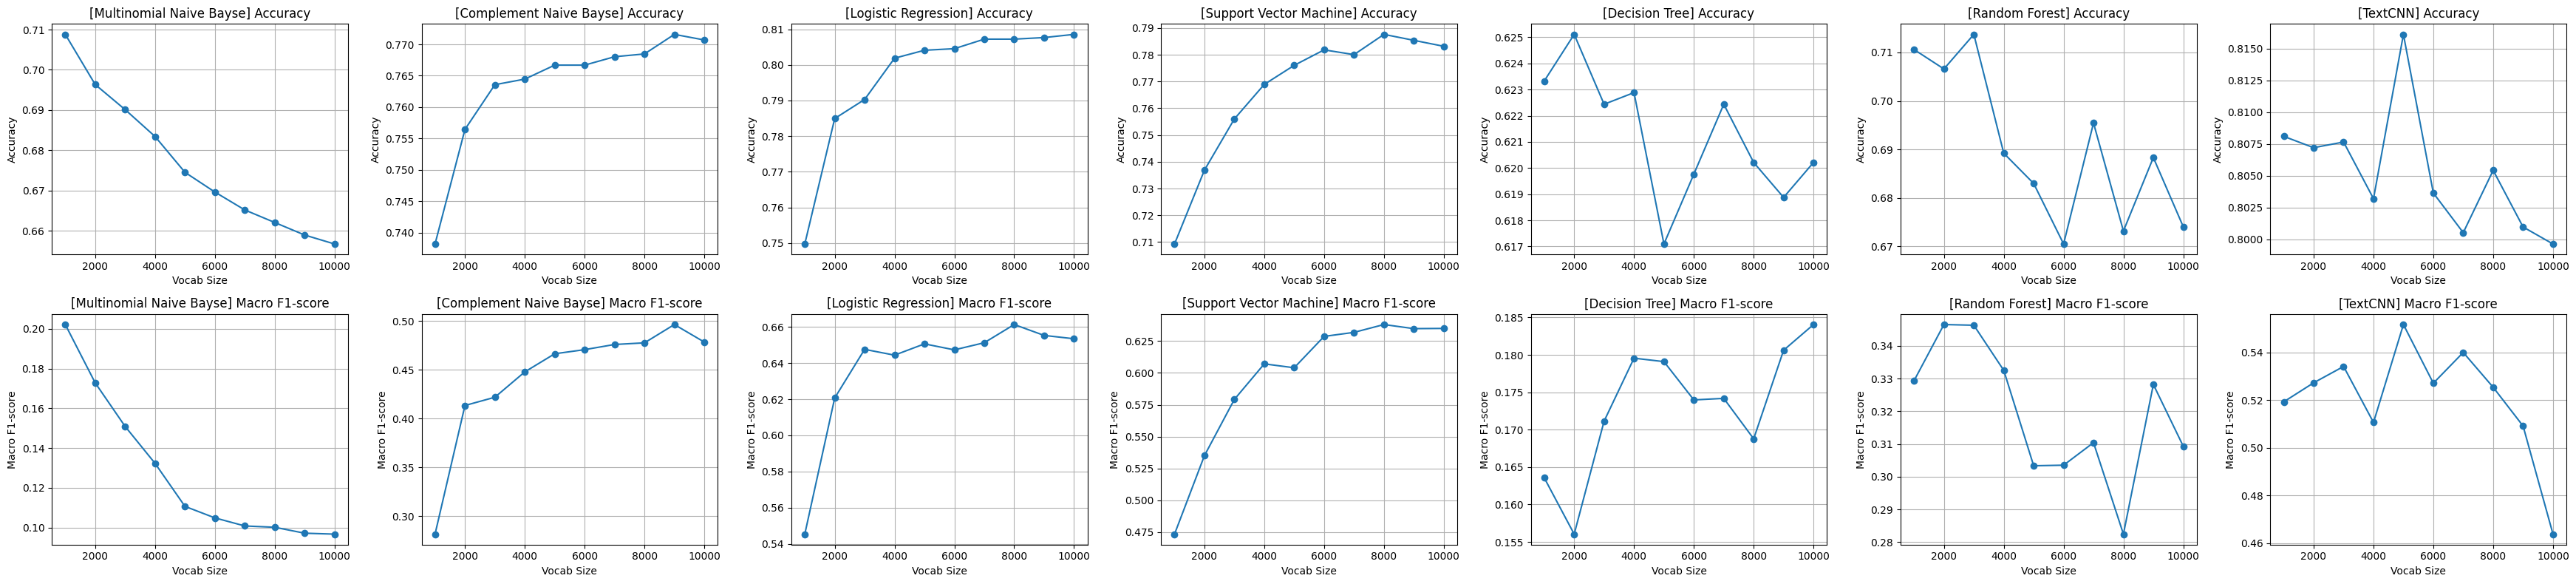

In [ ]:
models = build_models()

plot_metrics_by_vocab(results_df, exclude_minus_one=True)

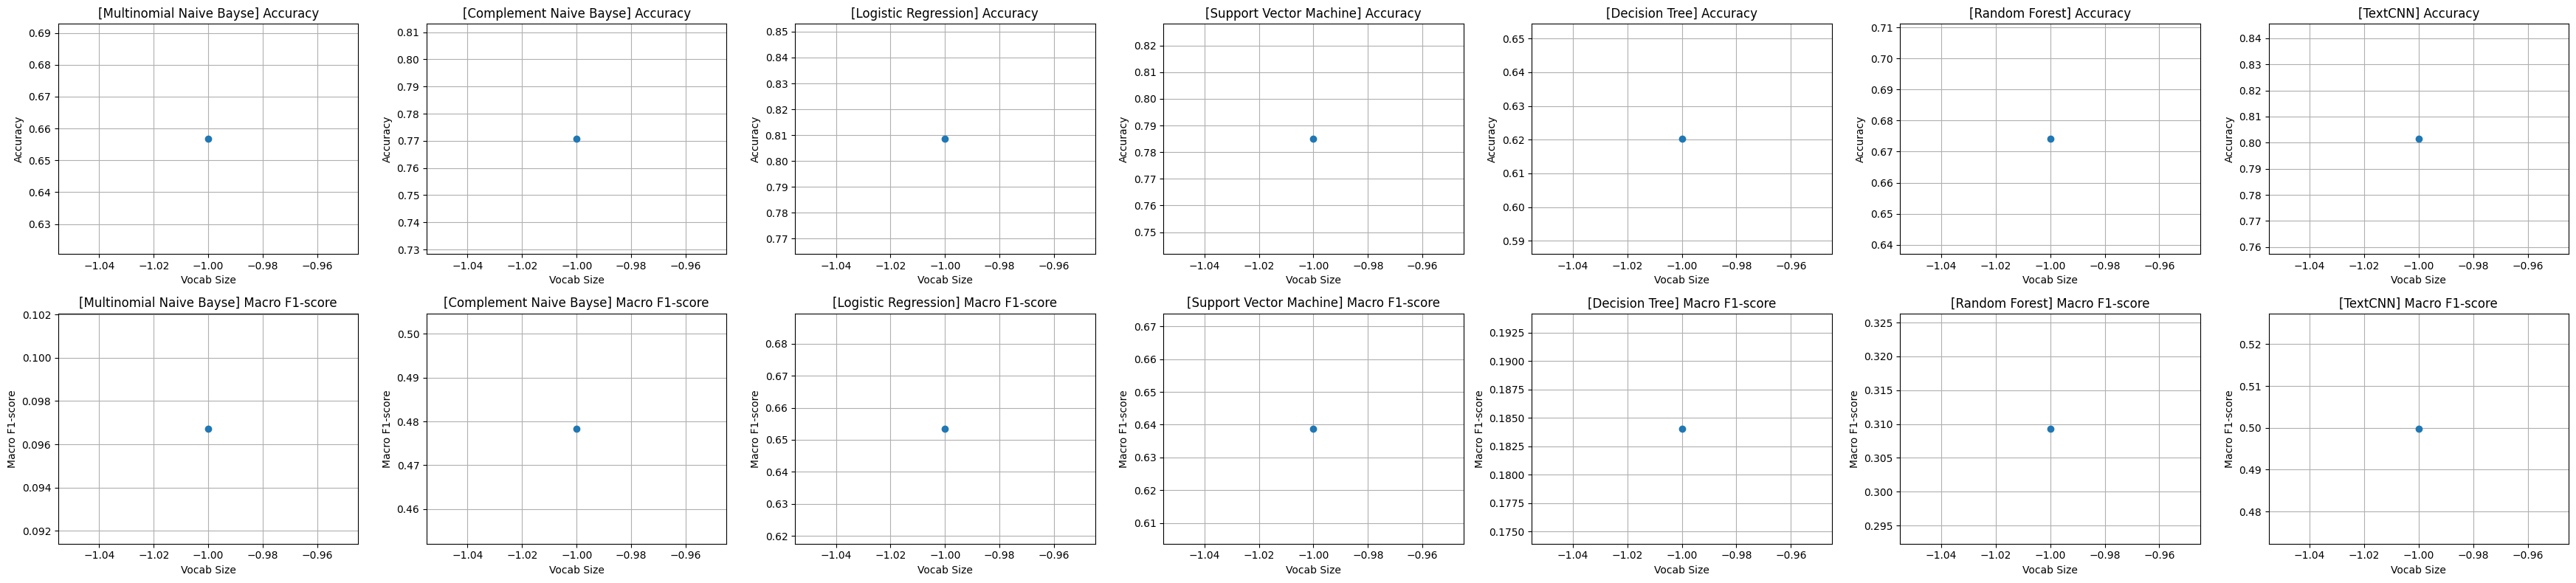

In [9]:
models = build_models()

plot_metrics_by_vocab(full_vocab_df, exclude_minus_one=False)

# 결과

- Naive Bayse : 1000에서 최고 성능 acc 71%, f1 0.2를 보이고 계속 하락
- CMB : 3000에서 급격한 기울기 감소를 보이며 9000에서 최고 성능을 보임.
- LR : 4000 이후 급격한 기울기 감소를 보이며 9000에서 최고 성능을 보임. 9000이후는 f1 score가 하락하는 것을 보아 과적합으로 의심됨.
- SVM은 6000이후 급격한 기울기 감소를 보이며 8000에서 최고 성능을 보임.
- DT는 전체적으로 accuracy는 하락하는 추세를, f1은 상승하는 추세를 보이나 변동성이 크다. 이는 모델의 ...한 특성으로 인해 발생한 결과로 보인다. 굳이 최적 점을 찾자면 둘 다 평균 이상으로 높은 4000 정도가 적당해 보인다.
- RF는 3000에서 최고 성능을 보이고 이후 하락 추세를 보이나 역시 변동성이 크다.
- TextCNN은 5000에서 acc 81.5%,f1 약 0.558로 최고 성능을 보이고 전후로 해서 기울기가 급격하게 변하는 모습이 나타난다.

|모델 이름|최적 vocab size|accuracy|f1-macro score|
|--------|----------------|--------|--------------|
|Multinominal Naive Bayse|1000|0.71|0.2|
|Complement Naive Bayse|9000|0.77|0.5|
|Logistic Regression|9000|0.81|0.655|
|Support Vector Machine|8000|0.79|0.64|
|Decision Tree|4000|0.623|0.18|
|Random Forest|3000|0.715|0.35|
|TextCNN|5000|0.816|0.555|

- 최고 성능을 보이는 시점을 기준으로 비교하면 TextCNN과 Logistic Regression이 높은 성능을 보이며 f1-score까지 고려한다면 최적의 모델은 Logistic Regression이라고 할 수 있다.
- Decision Tree나 Multinominal Naive Bayse와 같이 모델 성능이 높은 것과 별개로 f1 score는 터무니없이 낮은 값을 보이는 모델도 있으며 이는 학습 데이터에 특정 클래스의 데이터가 많이 존재하는 데이터의 편향으로 인해 발생하는 것으로 추정된다.

# 회고

시간이 조금 더 있었다면 나머지 두 모델(Gradient Boosting, Voting)도 성능 비교를 할 수 있었을텐데 아쉽다.

TextCNN 모델을 처음에 잘못 설계하여 구현하면서 성능 향상을 위한 고민을 하는 시간이 길었다.

실험 설계 당시 가설 설정 및 변인 통제에만 집중하다보니 함수 구현 시 데이터의 편향성, 모델의 특성을 고려하며 입출력을 설정하지 못해 해당 오류를 발견하는 데 시간이 소요되었다.